In [1]:
import pandas as pd 
import numpy as np
from os import listdir
from itertools import combinations, product  
from scipy.signal import find_peaks 
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
from tqdm import tqdm

%matplotlib inline

In [2]:
#config constraints 
tolerance = 0.5
protein = "Ubiquitin"

#subscript formatting for strings
SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

In [3]:
data_read_path = "..//Data//"
compound_list_path = data_read_path + "Compound Constraints//"
spectra_path = data_read_path + "Deconvoluted Spectra//"

#read in data
spectra_files = listdir(spectra_path)
bound_df = pd.read_excel(spectra_path+spectra_files[0])
unbound_df = pd.read_excel(spectra_path+spectra_files[1])


compounds_files = listdir(compound_list_path)
compounds = pd.read_excel(compound_list_path+compounds_files[0])

In [4]:
#files used

print("unbound: ", spectra_files[1])
print("bound: ", spectra_files[0])

unbound:  Ubi_1in100_broad band_000001.xlsx
bound:  Ubiquitin_plusC_1in100_000001.xlsx


In [5]:
#xtract information about Ub and the other compounds
other_compounds_df = compounds[compounds.Name != protein] #extract all compounds but Ub
protein_df = compounds[compounds.Name == protein] #extract Ub information

## Create Binding List

Create theoretical list of possible combinations of drug bindings

In [7]:
#create binding list
#binding list contains bonded compound and masses
binding_df = pd.DataFrame([])
number_of_compounds = other_compounds_df.shape[0]

for k in tqdm(range(1, number_of_compounds+1)):

    print("Level: ", str(k))

    #how many ways can you select k items from a list of n (where n=number of compounds, k=length of combinations)
    #use ID's as from ID's we can extract the masses and compound names
    combs = combinations(other_compounds_df.ID,k)
    #combs gives you the compounds to be bonded together

    #create binding elements and total masses
    for bonded_compound_ids in combs:

        print("Number of combinations: ", str(len(list(combs))))

        unbounded_molecule_formula = protein_df["Formula"].values[0].translate(SUB) #Base Ub symbol
        unbounded_molecule_mass = protein_df["Mass"].values[0] #Base Ub mass

        if len(bonded_compound_ids) == 1:
            idx = bonded_compound_ids[0]

            molecule = other_compounds_df.loc[other_compounds_df.ID == idx, "Formula"].values[0].translate(SUB)

            min_value = other_compounds_df.loc[other_compounds_df.ID == idx, "Min"].values[0]
            max_value = other_compounds_df.loc[other_compounds_df.ID == idx, "Max"].values[0]

            if min_value == 0:
                min_value = 1
            tolerance_seq = list(range(min_value, max_value+1))

            if max_value > 0:
                for multiplier in tolerance_seq:
                    
                        #single compound bonding 
                        permutation_of_molecule = "(" + molecule + ")" + str(multiplier).translate(SUB)
                        bonded_compound = unbounded_molecule_formula + " + " + permutation_of_molecule
                        total_mass = unbounded_molecule_mass + (other_compounds_df.loc[other_compounds_df.ID == idx, "Mass"].values[0]*multiplier)
            
                        binding_df = binding_df.append(
                            pd.DataFrame({"Formula":bonded_compound, "Mass":total_mass, "Level":1, "Combs": str(bonded_compound_ids)}, index=range(1)),
                            ignore_index=True)
                    
        else:
            #if more than 1 molecule is being considered
            level = len(bonded_compound_ids)
            prev_level = level - 1
            compounds_considered_at_prev_level = bonded_compound_ids[:-1]
            compound_to_be_considered = bonded_compound_ids[-1]
            
            max_value = other_compounds_df.loc[other_compounds_df.ID == compound_to_be_considered, "Max"].values[0]
            min_value = other_compounds_df.loc[other_compounds_df.ID == compound_to_be_considered, "Min"].values[0]
            molecule = other_compounds_df.loc[other_compounds_df.ID == compound_to_be_considered, "Formula"].values[0].translate(SUB)
            molecule_mass = other_compounds_df.loc[other_compounds_df.ID == compound_to_be_considered, "Mass"].values[0]

            if min_value == 0:
                min_value = 1
            tolerance_seq = list(range(min_value, max_value+1))

            #extract previous level
            search = binding_df[(binding_df["Level"] == prev_level) & (binding_df["Combs"] == str(compounds_considered_at_prev_level))]
            print("Number of previous level combinations: ", str(len(search.index)))
            for row_idx in search.index:
                bounded_compound_formula = search.loc[row_idx, "Formula"]
                bounded_compound_mass = search.loc[row_idx, "Mass"]

                if max_value > 0:
                    for multiplier in tolerance_seq:
                        permutation_of_molecule = "(" + molecule + ")" + str(multiplier).translate(SUB)
                        bonded_compound = bounded_compound_formula + " + " + permutation_of_molecule
                        total_mass = bounded_compound_mass + (molecule_mass*multiplier)
            
                        binding_df = binding_df.append(
                            pd.DataFrame({"Formula":bonded_compound, "Mass":total_mass, "Level":level, "Combs": str(bonded_compound_ids)}, index=range(1)),
                                ignore_index=True)



binding_df.index = range(binding_df.shape[0])
binding_df.to_csv("test.csv") #for testing

 18%|█▊        | 2/11 [00:00<00:00, 14.34it/s]Level:  1
Number of combinations:  10
Level:  2
Number of combinations:  54
Number of combinations:  3
Level:  3
Number of combinations:  164
Number of combinations:  18
 27%|██▋       | 3/11 [00:00<00:00, 12.46it/s]Level:  4
Number of combinations:  329
Number of combinations:  54
 36%|███▋      | 4/11 [00:00<00:01,  4.53it/s]Level:  5
Number of combinations:  461
Number of combinations:  324
 45%|████▌     | 5/11 [00:01<00:02,  2.06it/s]Level:  6
Number of combinations:  461
Number of combinations:  648
 55%|█████▍    | 6/11 [00:04<00:04,  1.01it/s]Level:  7
Number of combinations:  329
Number of combinations:  1296
 64%|██████▎   | 7/11 [00:17<00:18,  4.66s/it]Level:  8
Number of combinations:  164
Number of combinations:  6480
 73%|███████▎  | 8/11 [04:37<04:04, 81.42s/it]Level:  9
Number of combinations:  54
Number of combinations:  32400
 73%|███████▎  | 8/11 [33:23<12:31, 250.45s/it]

KeyboardInterrupt



## Normalise Spectrums

In [6]:
def normalise(spectrum):
    sc = MinMaxScaler()
    spectrum["normalised_intensity"] = sc.fit_transform(spectrum["I"].values.reshape(-1,1))

    return spectrum

In [7]:
#normalise both spectrums
bound_df = normalise(bound_df)
unbound_df = normalise(unbound_df)

## Search Spectrum

Search spectrum for intense peaks and label the peaks with the adduct

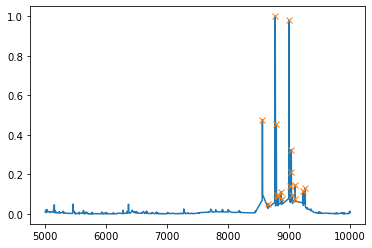

In [8]:
plt.plot(bound_df['m/z'], bound_df['normalised_intensity'])
peaks, _ = find_peaks(bound_df['normalised_intensity'], height=0.05)
plt.plot(bound_df['m/z'][peaks], bound_df['normalised_intensity'][peaks], "x")

In [9]:
peaks_found = bound_df.loc[peaks]
peaks_found

,Index,m/z,I,normalised_intensity
426,427,8564.62207,89167704,0.476840
434,435,8661.60527,10024730,0.051665
442,443,8774.61021,186549936,1.000000
455,456,8792.62576,85038176,0.454655
462,463,8811.59594,18592716,0.097695
469,470,8828.58489,17365306,0.091101
475,476,8871.56430,21293656,0.112205
483,484,8889.59348,14490540,0.075657
491,492,9001.61090,182734624,0.979503
500,501,9018.62575,26746588,0.141499


In [20]:
(lower_bound_mass < mass_peaks)

426    False
434    False
442    False
455    False
462    False
469     True
475     True
483     True
491     True
500     True
507     True
510     True
517     True
522     True
525     True
532     True
542     True
Name: m/z, dtype: bool

## Filter using binding list

In [32]:
#filter using max value
max_binding_mass = np.max(binding_df["Mass"]) #maximum possible mass from all theoretical binding sites
peaks_filtered = peaks_found[peaks_found["m/z"] < max_binding_mass]

In [33]:
#find sites by matching
binding_site_df = pd.DataFrame([])

for idx in peaks_filtered.index:
    mass = peaks_filtered.loc[idx, "m/z"]

    lower_bound = np.round(mass - tolerance)
    upper_bound = np.round(mass + tolerance)

    search_mask = (binding_df["Mass"] > lower_bound) & (binding_df["Mass"] < upper_bound)
    number_of_searches = np.sum(search_mask)
    

    if number_of_searches > 0:
        binding_site_df = binding_site_df.append(binding_df[search_mask], ignore_index=True)


In [34]:
binding_site_df

,Formula,Mass,Level,Combs
0,C₃₇₈H₆₃₀N₁₀₅O₁₁₈S₁ + (H₂O)₁ + (Cl)₁ + (Pt)₁ + ...,8871.714,4,"(1, 2, 3, 4)"
1,C₃₇₈H₆₃₀N₁₀₅O₁₁₈S₁ + (H₂O)₁ + (Cl)₂ + (Pt)₁ + ...,8871.622,4,"(1, 2, 3, 4)"
2,C₃₇₈H₆₃₀N₁₀₅O₁₁₈S₁ + (H₂O)₁ + (Cl)₁ + (Pt)₁ + ...,8889.748,4,"(1, 2, 3, 4)"
3,C₃₇₈H₆₃₀N₁₀₅O₁₁₈S₁ + (H₂O)₁ + (Cl)₂ + (Pt)₁ + ...,8889.656,4,"(1, 2, 3, 4)"
